# All Test case

0. test the DE function
  - mode 0: coeff = 1, single entry/exit
  - one reagent/product is involved in more than 1 step
  - stoichiometric coeff > 1
1. simple mechanism (no branching): test_v1
2. more than 1 cycles: test_v2
3. real example 

In [1]:
from kinetic_solver_v2 import *
import argparse 

In [2]:
# Input
parser = argparse.ArgumentParser(
    description='Perform kinetic modelling given the free energy profile and mechanism detail')

parser.add_argument(
    "-i",
    help="input reaction profiles in csv"
    )

parser.add_argument("-a", 
                    help="manually add an input reaction profile in csv", 
                    action="append")

parser.add_argument(
    "-c",
    "--c",
    type=str,
    default="c0.txt",
    help="text file containing initial concentration of all species [[INTn], [Rn], [Pn]]")

parser.add_argument(
    "-r",
    "--r",
    type=str,
    default="Rp.txt",
    help="reactant position matrix")

parser.add_argument(
    "-p",
    "--p",
    type=str,
    default="Pp.txt",
    help="product position matrix")

parser.add_argument(
    "-rn",
    "--rn",
    type=str,
    default="rxn_network,csv",
    help="reaction network matrix")

parser.add_argument(
    "--Time",
    type=float,
    default=1e8,
    help="total reaction time (s)")

parser.add_argument(
    "-t",
    "--t",
    type=float,
    default=298.15,
    help="temperature (K)")

parser.add_argument(
    "-de",
    "--de",
    type=str,
    default="LSODA",
    help="Integration method to use (odesolver)")

_StoreAction(option_strings=['-de', '--de'], dest='de', nargs=None, const=None, default='LSODA', type=<class 'str'>, choices=None, required=False, help='Integration method to use (odesolver)', metavar=None)

# 1. simple mechanism (no branching): test_v1

## loading data

In [5]:
dir = "test_cases/1/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

## Test DE function

- initial concentration:
   - cat: 0.2 M
   - R1: 0.6 M
   - R2: 0.5 M
   - INT1: 0.05 M
   - INT2: 0.02 M

In [ ]:
initial_conc[1] = 0.05
initial_conc[2] = 0.02

In [ ]:
def check_equal(true, sui, name):
    if true == sui: print(f"{name}: pass")
    else: print(f"{name}: should be revise")

### 0. mode 0

In [ ]:
y = initial_conc
dP0_dt_true = k_forward_all[0][3]*initial_conc[3] - k_reverse_all[0][3]*initial_conc[0]*initial_conc[6]
check_equal(dP0_dt_true, dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all), "dP_dt")

dR0_dt_true = -k_forward_all[0][0]*y[0]*y[4] + k_reverse_all[0][0]*y[1]
check_equal(dR0_dt_true, dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all), "dR_dt")

dINT0_dt_true = -k_forward_all[0][0]*y[0]*y[4] + k_reverse_all[0][0]*y[1] + k_forward_all[0][3]*y[3] - k_reverse_all[0][3]*y[0]*y[6]
check_equal(dINT0_dt_true, dINTa_dt(y, k_forward_all,k_reverse_all, rxn_network,Rp_, Pp_, 0, 0, n_INT_all), "dINT_dt")


dINT1_dt_true = k_forward_all[0][0]*y[0]*y[4] - k_reverse_all[0][0]*y[1] - k_forward_all[0][1]*y[1]*y[5] + k_reverse_all[0][1]*y[2]
check_equal(dINT1_dt_true, dINTa_dt(y, k_forward_all,k_reverse_all, rxn_network,Rp_, Pp_, 1, 0, n_INT_all), "dINT1_dt")

### Multiple reagent/Product
- suppose both R1 and R2 enter step 1 and R2 also enters step 2.\
INT0 + R1 + R2 <-> INT1 \
INT1 + R2 <-> INT2

In [ ]:
Rp[0,1] = 1.0
dR1_dt_true = -k_forward_all[0][0]*y[0]*y[4]*y[5] + k_reverse_all[0][0]*y[1] \
    -k_forward_all[0][1]*y[1]*y[5] + k_reverse_all[0][1]*y[2]

check_equal(dR1_dt_true, dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 1, n_INT_all), "Multiple reagent")

- suppose P0 is produced at both step 2 and 3\
INT2 <-> INT3 + P0 \
INT3 <-> INT0 + P0

In [ ]:
Pp[2] = 1
initial_conc[6] = 1
dP0_dt_true = k_forward_all[0][3]*initial_conc[3] - k_reverse_all[0][3]*initial_conc[0]*initial_conc[6] \
            + k_forward_all[0][2]*initial_conc[2] - k_reverse_all[0][2]*initial_conc[3]*initial_conc[6]
check_equal(dP0_dt_true, dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all), "Multiple product")

### stoichiometric coeff > 1

INT0 + 2*R1 <-> INT1 

In [ ]:
Rp[0,0] = 2
Rp[0,1] = 0
dR0_dt_true = -k_forward_all[0][0]*y[0]*y[4]**2 + k_reverse_all[0][0]*y[1]
check_equal(dR0_dt_true, dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all), "stoichiometric coeff > 1")

## All

The output directort already exists


mv: cannot move 'output' to 'test_cases/1/output': Directory not empty


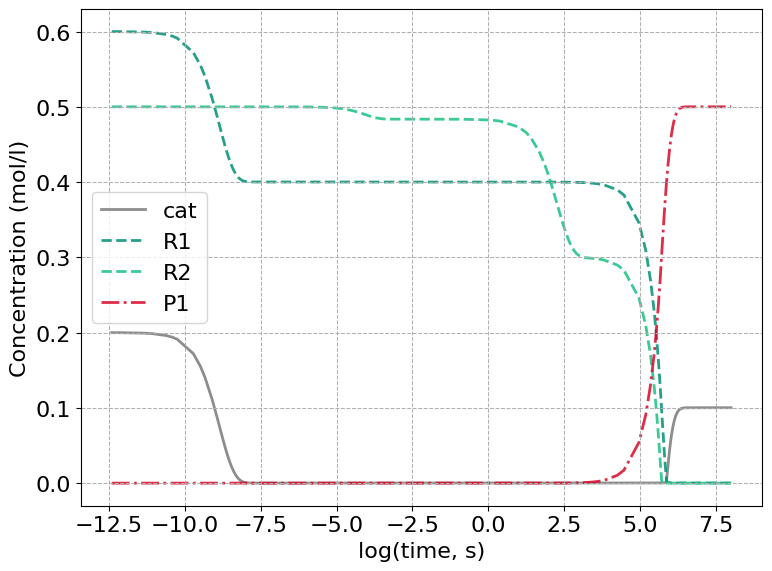

In [9]:
dydt = system_KE(
    k_forward_all,
    k_reverse_all,
    rxn_network,
    Rp_,
    Pp_,
    n_INT_all,
    initial_conc,
    jac_method="ag")

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=dydt.jac,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

-6.812119493487818e-07 0.0005497995831807056
-4.249644689905409e-07 0.0006056848620795126
-1.2784901573174255e-08 1.7117592511881582e-09
-3.284415754258428e-08 3.3788829921383566e-06
-1.115227291598585e-08 1.4495869494587556e-06
-5.978356877717017e-10 5.654343567271271e-07
-1.4125312473091005e-08 1.8221529176806836e-06
-6.634619355191528e-11 2.422770035057283e-08
-9.092681725744508e-10 -6.000851335092765e-07
-2.2928972048274978e-11 -1.6876150920347957e-08
-7.047739177408822e-10 -4.575740160293328e-07
-7.047739177408822e-10 -4.575740160293328e-07
-7.047739177408822e-10 -4.574290168730178e-07
-7.047739177408822e-10 0.01730944409638195
-7.047739177408822e-10 -4.575740160293328e-07
-7.047739177408822e-10 -4.575740160293328e-07
-7.047739177408822e-10 -4.575740160293328e-07
-7.066737636167682e-12 2.723669729855776e-09
-8.026509398420529e-17 2.5435583462978562e-20
-8.026509398420529e-17 2.5435583462978562e-20
-8.026509398420529e-17 2.611993638470937e-20
-8.026509398420529e-17 4.57425985017938

mv: cannot move 'output' to 'test_cases/1/output': Directory not empty


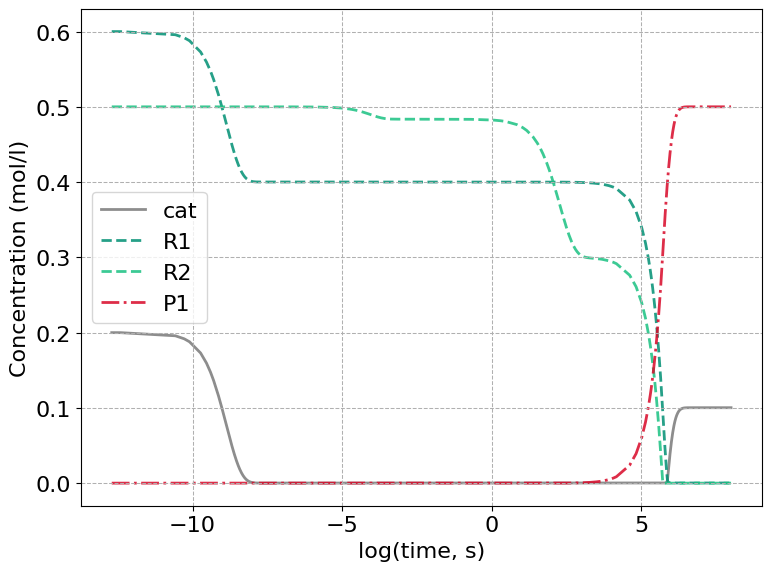

In [33]:
# def constraint_func(t, y):
#     # Constraint function
#     return np.sum(initial_conc) - np.sum(y)

# # lower_bound = np.zeros_like(initial_conc)

import jax.numpy as jnp
from jax import jacfwd, jit
from jax.config import config

def jac(t, y):
    return jacfwd(lambda _y: kinetic_system_de(t, y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all))(y)

result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method=method,
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
    # constraints=[{'fun': constraint_func, 'type': 'ineq'}],
    # bounds=(lower_bound, np.sum(initial_conc))
)

plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

In [21]:
lambda _y: kinetic_system_de(t, y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all)

<function __main__.<lambda>(_y)>

# 2. Multiple pathways

### 2.A. variation 0

In [10]:
dir = "test_cases/2A/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

The output directort already exists


mv: cannot move 'output' to 'test_cases/2A/output': Directory not empty


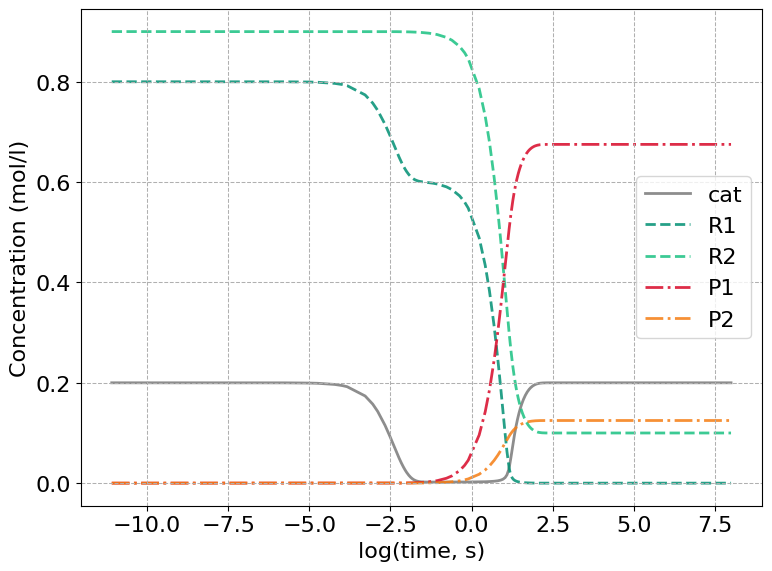

In [12]:
dydt = system_KE(
    k_forward_all,
    k_reverse_all,
    rxn_network,
    Rp_,
    Pp_,
    n_INT_all,
    initial_conc)

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=dydt.jac,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

#### Test DE function

In [21]:
y = initial_conc.copy()
y[1] = 0.05
y[2] = 0.01
y[3] = 0.004
y[4] = 0.05
y[5] = 0.08
y_INT = []
tmp = y[:np.sum(n_INT_all)]
y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])
# the first profile is assumed to be full, skipped
for i in range(len(k_forward_all)-1): # n_profile - 1
    i += 1
    # scaning rxn network column
    for j in range(rxn_network.shape[0]):
        if j >= np.cumsum(n_INT_all)[i-1] and j <= np.cumsum(n_INT_all)[i]: continue
        else: 
            if np.any(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],j]): 
                y_INT[i] = np.insert(y_INT[i], j, tmp[j])

y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all)+Rp_[0].shape[1]])
y_P = np.array(y[np.sum(n_INT_all)+Rp_[0].shape[1]:])

true_INT0 = -k_forward_all[0][0]*y_INT[0][0]*y_R[0] + k_reverse_all[0][0]*y_INT[0][1] \
        + k_forward_all[0][3]*y_INT[0][3]  - k_reverse_all[0][3]*y_INT[0][0]*y_P[0] \
        + k_forward_all[1][3]*y_INT[1][3]  - k_reverse_all[1][3]*y_INT[0][0]*y_P[1] 
print(f"At INT0 {true_INT0 - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, 0, n_INT_all)}")

true_INT1 = k_forward_all[0][0]*y_INT[0][0]*y_R[0] - k_reverse_all[0][0]*y_INT[0][1] \
        - k_forward_all[0][1]*y_INT[0][1]  + k_reverse_all[0][1]*y_INT[0][2] \
        - k_forward_all[1][1]*y_INT[0][1] + k_reverse_all[1][1]*y_INT[1][2]
print(f"At INT1 {true_INT1 - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 1, 0, n_INT_all)}")

dR1_true = -k_forward_all[0][0]*y_INT[0][0]*y_R[0] + k_reverse_all[0][0]*y_INT[0][1]
print(f"At R1 {dR1_true - dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all)}")


dP1_true = k_forward_all[0][3]*y_INT[0][3] - k_reverse_all[0][3]*y_INT[0][0]*y_P[0]
print(f"At P1 {dP1_true - dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all)}")

At INT0 0.0
At INT1 0.0
At R1 0.0
At P1 0.0


## 2.B

In [ ]:
dir = "test_cases/2B/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

In [ ]:
t_span = [0, 1e6]
result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method="Radau",
    dense_output=True,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
)

plot_save(result_solve_ivp, rxn_network, Rp_, Pp_)

In [ ]:
y = initial_conc.copy()
y[1] = 0.05
y[2] = 0.01
y[3] = 0.004
y[4] = 0.05
y[5] = 0.08
y[8] = 0.1
y_INT = []
tmp = y[:np.sum(n_INT_all)]
y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])
# the first profile is assumed to be full, skipped
for i in range(len(k_forward_all)-1): # n_profile - 1
    i += 1
    # scaning rxn network column
    for j in range(rxn_network.shape[0]):
        if j >= np.cumsum(n_INT_all)[i-1] and j <= np.cumsum(n_INT_all)[i]: continue
        else: 
            if np.any(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],j]): 
                y_INT[i] = np.insert(y_INT[i], j, tmp[j])

y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all)+Rp_[0].shape[1]])
y_P = np.array(y[np.sum(n_INT_all)+Rp_[0].shape[1]:])
dP1_true = k_forward_all[0][3]*y_INT[0][3] - k_reverse_all[0][3]*y_INT[0][0]*y_P[0] +\
    k_forward_all[1][3]*y_INT[1][3] - k_reverse_all[1][3]*y_INT[0][0]*y_P[0]
print(f"At P1 {dP1_true - dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all)}")
np.isclose(dP1_true, dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all))

## 2.C

In [ ]:
dir = "test_cases/2C/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)


t_span = [0, 1e6]
result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
)

plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

## 2.D. Pitfall

In [13]:
dir = "test_cases/2D/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

The output directort already exists


mv: cannot move 'output' to 'test_cases/2D/output': Directory not empty


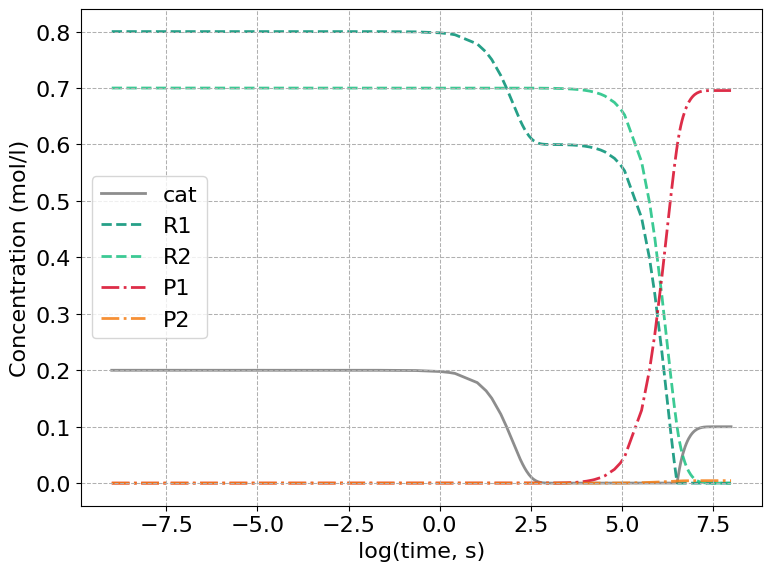

In [14]:
dydt = system_KE(
    k_forward_all,
    k_reverse_all,
    rxn_network,
    Rp_,
    Pp_,
    n_INT_all,
    initial_conc)

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=dydt.jac,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

In [6]:
initial_conc

array([0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0.7, 0. , 0. ])

The output directort already exists


mv: cannot move 'output' to 'test_cases/2D/output': Directory not empty


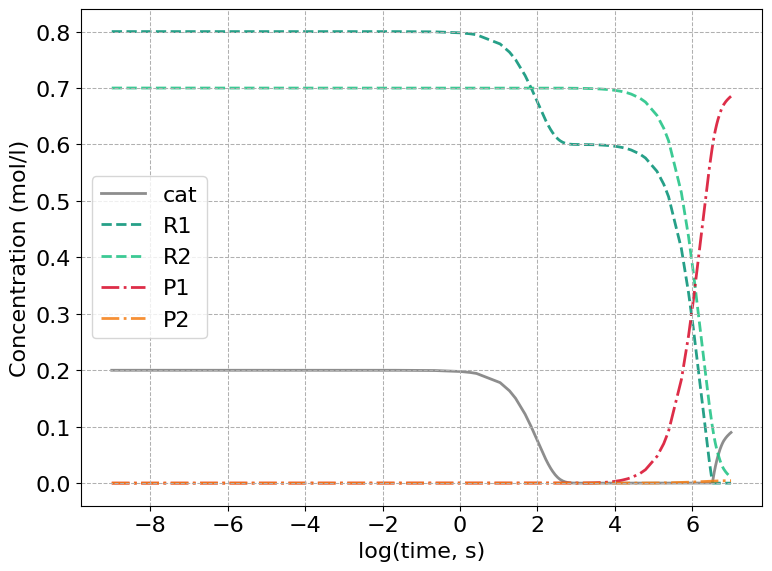

In [10]:
t_span = [0, 1e7]

result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
)

plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

In [ ]:
y = initial_conc.copy()
y[1] = 0.05
y[2] = 0.01
y[3] = 0.004
y[4] = 0.05
y[5] = 0.08
y[8] = 0.1
y[9] = 0.001


y_INT = []
tmp = y[:np.sum(n_INT_all)]
y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])

# the first profile is assumed to be full, skipped
for i in range(1,len(k_forward_all)): # n_profile - 1
    # pitfall
    if np.all(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],0] == 0):
        cp_idx = np.where(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],:][0] == -1)
        tmp_idx = cp_idx[0][0].copy()
        all_idx = [tmp_idx]
        while tmp_idx != 0:
            tmp_idx = np.where((rxn_network[tmp_idx,:] == -1))[0][0]
            all_idx.insert(0, tmp_idx)  
        y_INT[i] = np.insert(y_INT[i], 0, tmp[all_idx])
        
    else:
        for j in range(rxn_network.shape[0]):
            if j >= np.cumsum(n_INT_all)[i-1] and j <= np.cumsum(n_INT_all)[i]: continue
            else: 
                if np.any(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],j]): 
                    y_INT[i] = np.insert(y_INT[i], j, tmp[j])

y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all) + Rp_[0].shape[1]])
y_P = np.array(y[np.sum(n_INT_all) + Rp_[0].shape[1]:])

In [ ]:
true_INT1 = k_forward_all[0][0]*y_INT[0][0]*y_R[0] - k_reverse_all[0][0]*y_INT[0][1] \
        - k_forward_all[0][1]*y_INT[0][1]  + k_reverse_all[0][1]*y_INT[0][2] \
        - k_forward_all[1][1]*y_INT[0][1] + k_reverse_all[1][1]*y_INT[1][2] \
        - k_forward_all[2][1]*y_INT[0][1] + k_reverse_all[2][1]*y_INT[2][2]         
print(f"At INT1 {true_INT1 - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 1, 0, n_INT_all)}")

true_INT2_C = k_forward_all[2][1]*y_INT[0][1] - k_reverse_all[2][1]*y_INT[2][2]         
print(f"At INT2-C {true_INT2_C - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 2, 2, n_INT_all)}")

# Real: Cp

In [3]:
dir = "test_cases/Rh_Cp_2/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

In [4]:
dydt = system_KE(
    k_forward_all,
    k_reverse_all,
    rxn_network,
    Rp_,
    Pp_,
    n_INT_all,
    initial_conc,
    jac_method="cd")

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=dydt.jac,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

In [20]:
t_span = (0, 1e5)
dydt = system_KE(
        k_forward_all,
        k_reverse_all,
        rxn_network,
        Rp_,
        Pp_,
        n_INT_all,
        initial_conc)

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="LSODA",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

The output directort already exists


mv: cannot move 'output' to 'test_cases/Rh_Cp_2/output': Directory not empty


2.7056890692269335

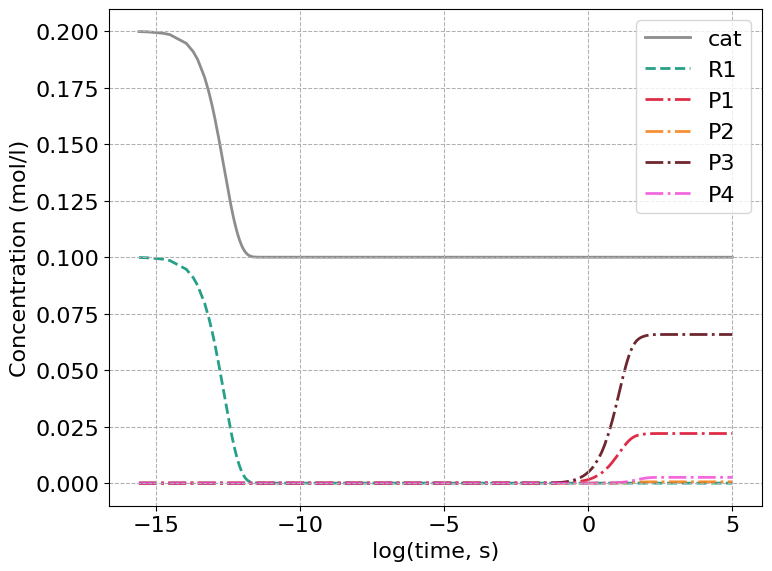

In [5]:
t_span = (0, 1e5)

def constraint_func(t, y):
    # Constraint function
    return np.sum(initial_conc) - np.sum(y)

lower_bound = np.zeros_like(initial_conc)

result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method=method,
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
    constraints=[{'fun': constraint_func, 'type': 'ineq'}],
    bounds=(lower_bound, np.sum(initial_conc))
)


plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)
(result_solve_ivp.y[-2][-1] + result_solve_ivp.y[-3][-1])/(result_solve_ivp.y[-1][-1] + result_solve_ivp.y[-4][-1])

In [38]:
y = initial_conc.copy()
y_INT = []
tmp = y[:np.sum(n_INT_all)]
y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])

# the first profile is assumed to be full, skipped
for i in range(1, len(k_forward_all)):  # n_profile - 1
    # pitfall
    if np.all(rxn_network[np.cumsum(n_INT_all)[i - 1]
                :np.cumsum(n_INT_all)[i], 0] == 0):
        cp_idx = np.where(rxn_network[np.cumsum(n_INT_all)[
                            i - 1]:np.cumsum(n_INT_all)[i], :][0] == -1)
        tmp_idx = cp_idx[0][0].copy()
        all_idx = [tmp_idx]
        while tmp_idx != 0:
            tmp_idx = np.where((rxn_network[tmp_idx, :] == -1))[0][0]
            all_idx.insert(0, tmp_idx)
        y_INT[i] = np.insert(y_INT[i], 0, tmp[all_idx])

    else:
        for j in range(rxn_network.shape[0]):
            if j >= np.cumsum(n_INT_all)[
                    i - 1] and j <= np.cumsum(n_INT_all)[i]:
                continue
            else:
                if np.any(rxn_network[np.cumsum(n_INT_all)[
                            i - 1]:np.cumsum(n_INT_all)[i], j]):
                    y_INT[i] = np.insert(y_INT[i], j, tmp[j])

y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all) + Rp_[0].shape[1]])
y_P = np.array(y[np.sum(n_INT_all) + Rp_[0].shape[1]:])

y_R

array([0.1])

In [34]:
dir = "test_cases/Rh_Cp_3/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

The output directort already exists


mv: cannot move 'output' to 'test_cases/Rh_Cp_3/output': Directory not empty


1.349744997639447

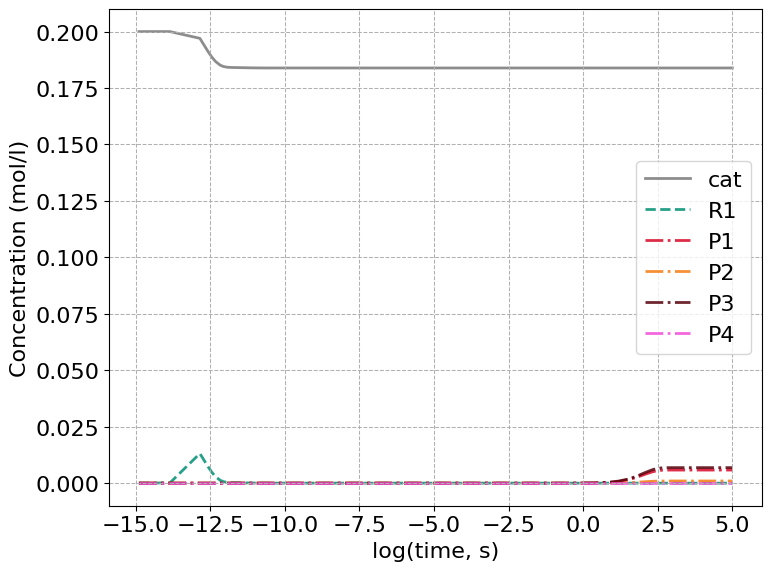

In [36]:
t_span = (0, 1e5)

# def constraint_func(t, y):
#     # Constraint function
#     return np.sum(initial_conc) - np.sum(y)

# lower_bound = np.zeros_like(initial_conc)
# upper_bound = np.full(len(initial_conc), np.sum(initial_conc))
# upper_bound[23] = initial_conc[23]

result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method="BDF",
    # first_step=first_step,
    # max_step=max_step,
    # rtol=1e-2,
    # atol=1e-6,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
    # constraints=[{'fun': constraint_func, 'type': 'ineq'}],
    # bounds=(lower_bound, upper_bound)
)


plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)
(result_solve_ivp.y[-2][-1] + result_solve_ivp.y[-3][-1])/(result_solve_ivp.y[-1][-1] + result_solve_ivp.y[-4][-1])

In [26]:
upper_bound = np.full(len(initial_conc), np.sum(initial_conc))
upper_bound[23] = initial_conc[23]
upper_bound[23]

0.1

# HBpin

In [10]:
dir = "test_cases/HBpin/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

In [11]:
t_span = (0, 86400*10)
t_eval = np.linspace(0, 86400*3, 1000)
dydt = system_KE(
        k_forward_all,
        k_reverse_all,
        rxn_network,
        Rp_,
        Pp_,
        n_INT_all,
        initial_conc)

result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="LSODA",
    t_eval=t_eval,
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=None,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

0 0.30000000000000004violated
1 -18.599814498290772violated
8 2.6violated
0 0.30000000000000004violated
1 -1.1624824768725635violated
8 2.6violated
9 -0.10000626994748643violated
9 -0.10010361599062441violated
9 -0.10000626994748643violated
9 -0.10708276349368771violated
9 -0.10676028342717993violated
9 -0.10652499671887097violated
9 -0.10708276349368771violated
9 -0.10699328640233337violated
9 -0.11627477250050826violated
9 -0.11615675815321255violated
9 -0.1216075585852787violated
9 -0.12336829419852145violated
9 -0.12118115540441465violated
9 -0.11404151214179499violated
9 -0.10172693179325215violated
2 -31.639310899763913violated
3 5.3violated
9 -31.701136023950816violated
0 0.30000000000000004violated
1 5.3violated
2 5.3violated
3 5.3violated
4 5.3violated
5 5.3violated
6 5.3violated
7 5.3violated
8 2.6violated
9 1.35violated
10 1.35violated
11 5.3violated
12 5.3violated
0 -1407340.0970880322violated
2 -155.39719102842008violated
5 5.3violated
8 2.6violated
9 -5214.962944758392vio

In [20]:
t_eval = np.linspace(0, 86400*3, 1000)
t_span = (0, 86400*10)

result_solve_ivp = solve_ivp(
    kinetic_system_de,
    t_span,
    initial_conc,
    method=method,
    t_eval=t_eval,
    jac=None,
    args=(k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all),
    # constraints=[{'fun': constraint_func, 'type': 'ineq'}],
    # bounds=(lower_bound, upper_bound)
)

NameError: name 'result_solve_ivp' is not defined

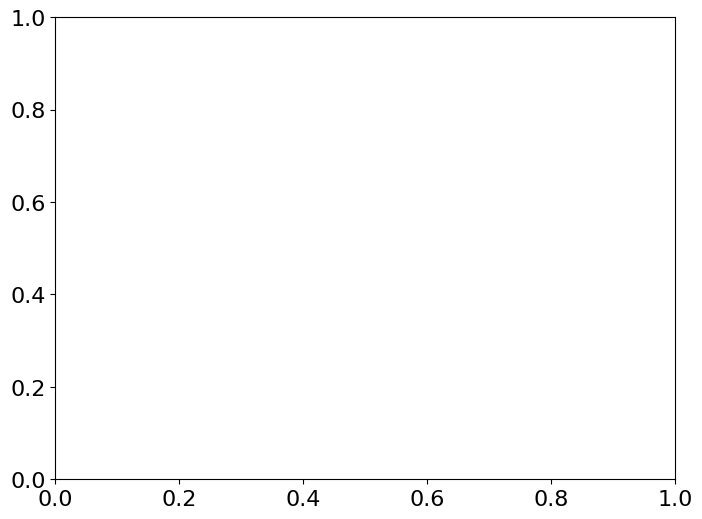

In [2]:
import matplotlib.pyplot as plt
plt.rc("axes", labelsize=16)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("font", size=16)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(result_solve_ivp.t,
        result_solve_ivp.y[0, :],
        c="#797979",
        linewidth=2,
        alpha=0.85,
        zorder=1,
        label='cat')

博衣 = ["#008F73", "#1AC182", "#1AC145", "#7FFA35", "#8FD810", "#ACBD0A"]
for i in range(Rp_[0].shape[1]):
    ax.plot(result_solve_ivp.t,
            result_solve_ivp.y[rxn_network.shape[0] + i, :],
            linestyle="--",
            c=博衣[i],
            linewidth=2,
            alpha=0.85,
            zorder=1,
            label=f'R{i+1}')

こより = ["#D80828", "#F57D13", "#55000A", "#F34DD8", "#C5A806", "#602AFC"]
for i in range(Pp_[0].shape[1]):
    ax.plot(result_solve_ivp.t,
            result_solve_ivp.y[rxn_network.shape[0] + Rp_[0].shape[1] + i, :],
            linestyle="dashdot",
            c=こより[i],
            linewidth=2,
            alpha=0.85,
            zorder=1,
            label=f'P{i+1}')


plt.xlabel('time, s')
plt.ylabel('Concentration (mol/l)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.75)
plt.tight_layout()

In [28]:
len(result_solve_ivp.y[0])

1000

In [31]:
Rp_[0].shape[1]

3

In [32]:
n_INT_all

array([8])

In [12]:
s = "        1.523874   -0.392000    0.075712"
s_list = s.split()
s_formatted = "   ".join([f"{float(x):.5f}" for x in s_list])
s_formatted = "        "+s_formatted

'        1.52387   -0.39200   0.07571'

In [2]:
import numpy as np

y = np.loadtxt("test_cases/1/c0.txt")
np.sqrt(np.finfo(float).eps) * np.maximum(1.0, np.abs(y))

array([1.49011612e-08, 1.49011612e-08, 1.49011612e-08, 1.49011612e-08,
       1.49011612e-08, 1.49011612e-08, 1.49011612e-08])

In [4]:
np.finfo(float).eps

2.220446049250313e-16